In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tqdm
from scipy.signal import find_peaks

plt.style.use(['science', 'grid', 'notebook'])

# Neurona Hogdkin-Huxley

In [2]:
# Definición de constantes del sistema
Vna = 50    # mV
Vk = -77
Vl = -54.4
gna = 120   # mS/cm^2
gk = 36
gl = 0.3

C = 1   # microF/cm^2

# Definición de funciones de comportamiento de la membrana
def alpha_m(V):
    return 0.1 * (V + 40) / (1 - np.exp(-0.1 * (V + 40)))
def beta_m(V):
    return 4 * np.exp(-(V + 65) / 18)
def alpha_h(V):
    return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V):
    return 1 / (1 + np.exp(-0.1 * (V + 35)))
def alpha_n(V):
    return 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))
def beta_n(V):
    return 0.125 * np.exp(-(V + 65) / 80)

# definicion de X_inf y tau_x
def x_inf(V):
    return np.array([alpha_m(V) / (alpha_m(V) + beta_m(V)), alpha_h(V) / (alpha_h(V) + beta_h(V)), alpha_n(V) / (alpha_n(V) + beta_n(V))])

def tau_x(V):
    return np.array([1 / (alpha_m(V) + beta_m(V)), 1 / (alpha_h(V) + beta_h(V)), 1 / (alpha_n(V) + beta_n(V))])

Resolvedor de ecuaciones diferenciales usando el método de Euler a primer orden.

In [1]:
def euler_eq_resolver(seed, time_limits, delta_t, dydx, args):
    time_axis = np.arange(*time_limits, delta_t)    # defino eje temporal
    results = np.empty((*seed.shape, time_axis.size))            # defino matriz de potencial de membrana y variables de comportamiento
    results[:, 0] = seed

    for i in range(1, time_axis.size):
        results[:, i] = results[:, i - 1] + delta_t * dydx(results[:, i - 1], args)
    return results

Defino limites, constantes y resuelvo el sistema

In [6]:
delta_t = 0.005         # paso temporal
time_limits = (0, 200)  # limites temporales
V0 = -60                # potencial de membrana inicial
n_intensities = 100     # cantidad de intensidades de corriente
I_limits = (-15, 30)
plot = False

time_axis = np.arange(*time_limits, delta_t)    # defino eje temporal
results = np.empty((n_intensities, 4, time_axis.size))            # defino matriz de potencial de membrana y variables de comportamiento
I = np.linspace(*I_limits, n_intensities)       # defino corriente aplicada
# I = -15

# condiciones iniciales
seed = np.array([V0, *0.9*x_inf(V0)]) # la condicion inicial cerca del potencial de reposo

# definicion de la ecuacion diferencial
def dVdt(V, m, h, n, args):
    gna, gk, gl, Vna, Vk, Vl, I = args
    return (I - gna * m**3 * h * (V - Vna) - gk * n**4 * (V - Vk) - gl * (V - Vl)) / C

def dxdt(x, V):
    return (x_inf(V) - x) / tau_x(V)

def derivate_system(x, args):
    return np.array([dVdt(x[0], *x[1:], args), *dxdt(x[1:], x[0])])

frecuencias = np.empty(n_intensities)   # vector de frecuencias de disparo

# resolucion de la ecuacion diferencial
for i, i_ in tqdm.tqdm(enumerate(I), total=n_intensities, desc='Intensidades'):
    results[i] = euler_eq_resolver(seed, time_limits, delta_t, derivate_system, [gna, gk, gl, Vna, Vk, Vl, i_])
    peaks, _ = find_peaks(results[i, 0, :], height=0)
    if len(peaks) > 1:
        frecuencias[i] = len(peaks) / (time_axis[peaks[-1]] - time_axis[peaks[0]])
    else:
        frecuencias[i] = 0
    
    if plot:
        plt.plot(time_axis, results[i, 0, :], label=f'I = {i_:.2f}uA/cm^2')
        plt.plot(time_axis[peaks], results[i, 0, peaks], 'x')
        print(len(peaks))
        plt.legend(fontsize='small')

Intensidades: 100%|██████████| 100/100 [01:03<00:00,  1.58it/s]


Text(0, 0.5, 'Frecuencia (Hz)')

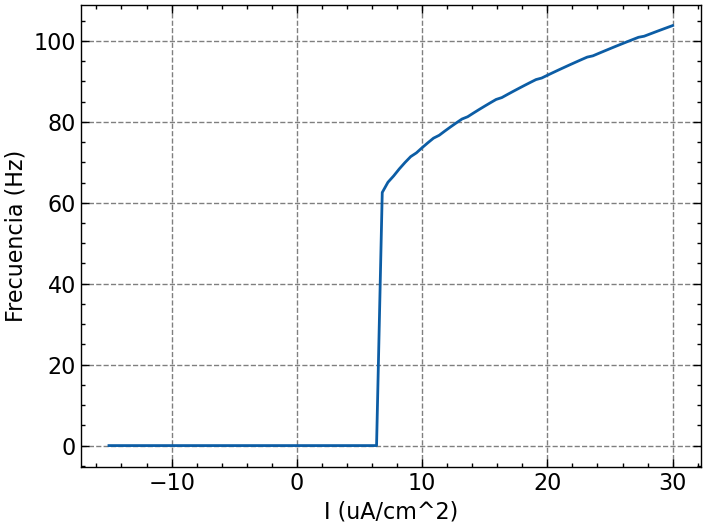

In [7]:
plt.plot(I, frecuencias*1000, '-')
plt.xlabel('I (uA/cm^2)')
plt.ylabel('Frecuencia (Hz)')

Si ahora $m(t) = m_\infty (V)$

In [9]:
# las derivadas para h y n permanecen igual
def hn_inf(V):
    return np.array([alpha_h(V) / (alpha_h(V) + beta_h(V)), alpha_n(V) / (alpha_n(V) + beta_n(V))])

def hn_tau(V):
    return np.array([1 / (alpha_h(V) + beta_h(V)), 1 / (alpha_n(V) + beta_n(V))])

def dxdt2(x, V):
    return (hn_inf(V) - x) / hn_tau(V)

def m_inf(V):
    return alpha_m(V) / (alpha_m(V) + beta_m(V))

In [23]:
results = np.empty((n_intensities, 4, time_axis.size))            # defino matriz de potencial de membrana y variables de comportamiento
# condiciones iniciales
seed = np.array([V0, *0.9*x_inf(V0)]) # la condicion inicial cerca del potencial de reposo

I = np.linspace(*I_limits, n_intensities)       # defino corriente aplicada
frecuencia_2 = np.empty(n_intensities)           # vector de frecuencias de disparo

for j, i_ in tqdm.tqdm(enumerate(I), total=n_intensities, desc='Intensidades'):
    for i in range(time_axis.size):
        results[0, 0, i] = results[0, 0, i-1] + delta_t * dVdt(results[0, 0, i-1], *results[0, 1:, i-1], [gna, gk, gl, Vna, Vk, Vl, i_])
        results[0, 1, i] = m_inf(results[0, 0, i])
        results[0, 2:, i] = results[0, 2:, i-1] + delta_t * dxdt2(results[0, 2:, i-1], results[0, 0, i-1])
    peaks, _ = find_peaks(results[0, 0, :], height=10)
    if len(peaks) > 1:
        frecuencia_2[j] = len(peaks) / (time_axis[peaks[-1]] - time_axis[peaks[0]])
    else:
        frecuencia_2[j] = 0


Intensidades: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


Text(0, 0.5, 'Frecuencia (Hz)')

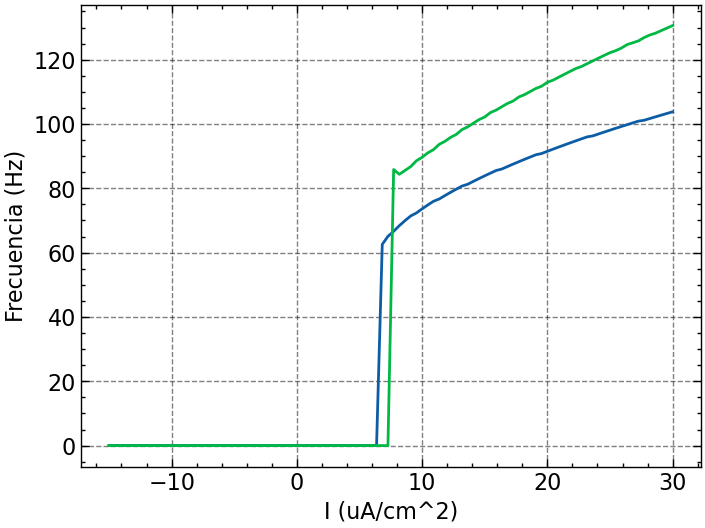

In [25]:
plt.plot(I, frecuencias*1000, '-', label='Modelo 1')
plt.plot(I, frecuencia_2*1000, '-', label='Modelo 2')
plt.xlabel('I (uA/cm^2)')
plt.ylabel('Frecuencia (Hz)')
